In [87]:
import torch
from torch import nn


class MLPModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len, hidden):
        super(MLPModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  # Number of one-hot encoded genres
        self.latent_dim_len = latent_dim_len
        self.hidden_layer = hidden

        # Embedding layers for user and anime
        self.uid_embedding = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding.to(device)
        self.animeid_embedding.to(device)

        self.layers = nn.ModuleList()

        # Combine user, item, and non-embedding features
        input_dim = self.latent_dim_len * 2 + 2 + self.genre_count

        # Hidden layers with ReLU activation, from paper
        for dim in self.hidden_layer:
            self.layers.append(nn.Linear(in_features=input_dim, out_features=dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            input_dim = dim

        # Output layer with ReLU activation
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_layer[-1], out_features=1),
            nn.ReLU())  

        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        uid_e = self.uid_embedding(uid_index)
        animeid_e = self.animeid_embedding(animeid_index)
        episodes = episodes.unsqueeze(1) 
        type = type.unsqueeze(1) 

        model_input = torch.cat([uid_e, animeid_e, episodes, type, genre], dim=-1)

        # Pass input through hidden layers
        for hidden_layer in self.layers:
            model_input = hidden_layer(model_input)

        # Compute final output score 
        score = self.output_layer(model_input)
        return score.squeeze()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

In [88]:
import torch
from torch import nn


class NeuMFModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len, hidden):
        super(NeuMFModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  # Number of one-hot encoded genres
        self.latent_dim_len = latent_dim_len
        self.hidden_layer = hidden

        # Embedding layers for user and anime
        self.uid_embedding_gmf = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding_gmf = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding_mlp = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding_mlp = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)

        # Define the layers of the MLP
        self.layers = nn.ModuleList()

        # Combine user, item, and non-embedding features
        input_dim = self.latent_dim_len * 2 + 2 + self.genre_count

        for dim in self.hidden_layer:
            self.layers.append(nn.Linear(in_features=input_dim, out_features=dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            input_dim = dim

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_layer[-1] + self.latent_dim_len, out_features=1),
            nn.Sigmoid()) 

        # Initialize weights
        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        # Get user and item embeddings
        uid_mlp = self.uid_embedding_mlp(uid_index)
        animeid_mlp = self.animeid_embedding_mlp(animeid_index)
        uid_gmf = self.uid_embedding_gmf(uid_index)
        animeid_gmf = self.animeid_embedding_gmf(animeid_index)
        

        episodes = episodes.unsqueeze(1)  # (batch_size, 1)
        type = type.unsqueeze(1)  # (batch_size, 1)
        # Concatenate all features into one vector
        model_input = torch.cat([uid_mlp, animeid_mlp, episodes, type, genre], dim=-1)
        product = torch.mul(uid_gmf, animeid_gmf)

        # Pass input through hidden layers
        for hidden_layer in self.layers:
            model_input = hidden_layer(model_input)
            product = torch.nn.ReLU()(product)

        # Compute final output score (prediction)
        vector = torch.cat([model_input, product], dim=-1)
        score = self.output_layer(vector)
        return score.squeeze()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

    def pretrain_loader(self):
        mlp_model = MLPModel(uid_count=uid_count,
                         animeid_count=animeid_count,
                         genre_count=genre_count,
                         latent_dim_len=latent_dim_len,
                         hidden=hidden_layers)

        gmf_model = GMFModel(uid_count=uid_count,
                         animeid_count=animeid_count,
                         genre_count=genre_count,
                         latent_dim_len=latent_dim_len)

        # Move models to GPU
        mlp_model.cuda()
        gmf_model.cuda()

        # Load the weights from pre-trained models
        mlp_model.load_state_dict(torch.load('models/mlp_model.pth'))
        gmf_model.load_state_dict(torch.load('models/gmf_model.pth'))

        # Load the embedding layers from the MLP and GMF models into NeuMF
        self.uid_embedding_mlp.weight.data = mlp_model.uid_embedding.weight.data
        self.animeid_embedding_mlp.weight.data = mlp_model.animeid_embedding.weight.data
        self.uid_embedding_gmf.weight.data = gmf_model.uid_embedding.weight.data
        self.animeid_embedding_gmf.weight.data = gmf_model.animeid_embedding.weight.data

        # Load the MLP hidden layers' weights into the NeuMF model
        for i in range(len(self.layers)):
            if isinstance(self.layers[i], nn.Linear):
                # Only load weights for Linear layers
                self.layers[i].weight.data = mlp_model.layers[i].weight.data
                self.layers[i].bias.data = mlp_model.layers[i].bias.data

In [89]:
import torch
from torch import nn


class GMFModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len):
        super(GMFModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  
        self.latent_dim_len = latent_dim_len

        self.uid_embedding = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding.to(device)
        self.animeid_embedding.to(device)

        self.dropout = nn.Dropout(0.3)

        input_dim = self.latent_dim_len + 2 + self.genre_count
        
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=1),
            nn.Sigmoid())  # ReLU for output layer can be replaced by sigmoid or identity depending on task

        # Initialize weights
        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        # Get user and item embeddings
        uid_e = self.uid_embedding(uid_index)
        animeid_e = self.animeid_embedding(animeid_index)
    
        product = uid_e * animeid_e 
        product = self.dropout(product)

        episodes = episodes.unsqueeze(1)  
        type = type.unsqueeze(1)  
        genre = genre.squeeze(1)  

        # Concatenate all features into one vector
        model_input = torch.cat([product, episodes, type, genre], dim=-1)

        # Pass input through the output layer
        score = self.output_layer(model_input)
        return score.squeeze()


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

class AnimeData(object):
    def __init__(self, ratings, anime):
        self.ratings = ratings
        self.anime = anime
        encoder = LabelEncoder()

        # Remove data where user did not rate anime
        self.ratings = self.ratings.loc[self.ratings.iloc[:, 2] != -1]

        # Remove overall members and rating -> not needed
        self.anime.drop(['members', 'rating'], axis=1, inplace=True)

        # anime_id,name,genre,type,episodes,rating,members
        # user_id,anime_id,rating

        # Encode the IDs to an integer mapping for embedding
        self.ratings['user_id'] = self.ratings['user_id'].astype("category").cat.codes
        self.ratings['anime_id'] = self.ratings['anime_id'].astype("category").cat.codes
        self.anime['anime_id'] = self.anime['anime_id'].astype("category").cat.codes
        self.anime = self.anime[self.anime['episodes'] != 'Unknown']

        # Encode the name and type
        self.anime['name'] = encoder.fit_transform(self.anime['name'])
        self.name_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
        self.anime['type'] = encoder.fit_transform(self.anime['type'])
        self.type_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

        # One hot encode the genres
        self.anime['genre'] = self.anime['genre'].str.split(', ')
        bin = MultiLabelBinarizer()
        onehot = bin.fit_transform(self.anime['genre'])
        dfs = pd.DataFrame(onehot, columns=bin.classes_)
        self.anime.drop('genre', axis=1, inplace=True)
        self.anime.reset_index(drop=True, inplace=True)
        dfs.reset_index(drop=True, inplace=True)
        self.genre = dfs
        self.anime = pd.concat([self.anime, dfs], axis=1)

        # Merge user and anime data into single dataset
        self.data = self.ratings.merge(self.anime, on='anime_id', how='left')
        self.data['rating'] = self.data['rating'] / 10

        self.data['episodes'] = self.data['episodes'].astype('int64')

        self.features = self.data[['user_id', 'anime_id', 'type', 'episodes']+ list(self.genre.columns)]
        self.target = self.data['rating']

        self.genre_cols = self.features.columns[5:]

    def process(self, item):
        # Encode the type and name
        tid = self.type_map[item[2]]  # "TV" -> Encoded type using your `type_map`
        #name = self.name_map[item[3]]  # Anime name -> Encoded name using your `name_map`
        
        # One-hot encode the genres
        genre_encoded = [1 if genre in item[5].split(", ") else 0 for genre in self.genre_cols]
        
        # Combine all the features into a single list
        dfn = [item[0],  # anime_id
               item[1],  # user_id
               tid,      # Encoded type
               item[4]]  # episodes
        dfn += genre_encoded  # Append the genre encoding
        
        # Return as a Pandas Series (1D array)
        cols = ['user_id', 'anime_id', 'type', 'episodes'] + list(self.genre.columns)
        return pd.Series(dfn, index=cols)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, item):
        x = self.features[item]
        y = self.target[item]
        if self.transform:
            x = self.transform(x)
        return x, y

    def get_loaders(self):
        train, test = train_test_split(self.data, test_size=0.2)

        train_user_item = torch.tensor(train[self.features.columns].values, dtype=torch.long)
        train_labels = torch.tensor(train['rating'].values, dtype=torch.float32)

        test_user_item = torch.tensor(test[self.features.columns].values, dtype=torch.long)
        test_labels = torch.tensor(test['rating'].values, dtype=torch.float32)

        train_set = TensorDataset(train_user_item[:, 0], # user_id
                                  train_user_item[:, 1], # anime_id
                                  train_user_item[:, 2], # type
                                  train_user_item[:, 3], # episodes
                                  train_user_item[:, 4:], # genres
                                  train_labels)
        test_set = TensorDataset(test_user_item[:, 0], # user_id
                                  test_user_item[:, 1], # anime_id
                                  test_user_item[:, 2], # type
                                  test_user_item[:, 3], # episodes
                                  test_user_item[:, 4:], # genres
                                  test_labels)

        train = DataLoader(train_set, batch_size=128, shuffle=True)
        test = DataLoader(test_set, batch_size=128, shuffle=True)

        return train, test



In [94]:
import pandas as pd
#from mlp import MLPModel
#from gmf import GMFModel
from torch import nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
df1 = pd.read_csv('data/anime.csv')
df2 = pd.read_csv('data/rating.csv')
df2 = df2[:1000000]


df1.dropna(inplace=True)
df2.dropna(inplace=True)
df2 = df2.loc[df2.iloc[:, 2] != -1]

df1 = df1[df1['episodes'] != 'Unknown']

handler = AnimeData(df2, df1)

uid_count = len(handler.ratings['user_id'].unique())  # Number of unique users
animeid_count = len(handler.anime['anime_id'].unique())  # Number of unique anime
genre_count = 43  # Number of one-hot encoded genre categories
latent_dim_len = 50  # Latent dimension length for embeddings
hidden_layers = [128, 64, 32, 16]  # Example hidden layers for MLP

# Initialize the MLP model

mlp_model = MLPModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len,
                 hidden=hidden_layers)

gmf_model = GMFModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len)

neumf_model = NeuMFModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len,
                 hidden=hidden_layers)

gmf_model.to(device)
mlp_model.to(device)
neumf_model.to(device)
a, b = handler.get_loaders()

loss_function = nn.MSELoss()
gmfo = torch.optim.Adam(gmf_model.parameters(), lr=0.0001)
mlpo = torch.optim.Adam(mlp_model.parameters(), lr=0.0001)
nfmo = torch.optim.Adam(neumf_model.parameters(), lr=0.0001)

newuser = [2948, 18671, "TV", "Chuunibyou demo Koi ga Shitai! Ren", 12, "Comedy, Drama, Romance, School, Slice of Life"]


def run_and_eval(a, b, model, opt, lr=0.001, epochs=10):
    optimizer = opt
    loss_function = nn .MSELoss()
    model.train()
    
    for i in range(epochs):
        model.train()
        total_loss = 0
        for user, anime, type,episodes, genre, labels in a:
            user, anime = user.to(device), anime.to(device)
            episodes, type, genre = episodes.to(device), type.to(device), genre.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(user, anime, episodes, type, genre)
            loss = loss_function(pred, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{i + 1}/{10}], Loss: {total_loss / len(a)}")

        model.eval()  # Set the model to evaluation mode
        total_loss = 0
        total_samples = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():  # Disable gradient calculation
            for user, anime, type, episodes, genre, labels in b:
                user, anime = user.to(device), anime.to(device)
                episodes, type, genre = episodes.to(device), type.to(device), genre.to(device)
                labels = labels.to(device)

                # Get model predictions
                pred = model(user, anime, episodes, type, genre)

                # Calculate the loss (e.g., MSE loss)
                loss = loss_function(pred, labels)
                total_loss += loss.item() * len(labels)  # Accumulate loss
                total_samples += len(labels)  # Accumulate the number of samples

                # Store predictions and actual values
                all_predictions.extend(pred.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average loss
        avg_loss = total_loss / total_samples
        print(f"Test Loss [{i+1}/10]: {avg_loss}")

    # Additional Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_predictions)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")


run_and_eval(a, b, mlp_model, mlpo, lr=0.0001, epochs=10)
#torch.save(mlp_model.state_dict(), 'mlp_model.pth')
print()
run_and_eval(a, b, gmf_model, gmfo, lr=0.0001, epochs=10)
#torch.save(gmf_model.state_dict(), 'gmf_model.pth')

neumf_model.pretrain_loader()
run_and_eval(a, b, neumf_model, nfmo, lr=0.0001, epochs=10)
torch.save(neumf_model.state_dict(), 'neumf_model.pth')

Using device: cuda
Epoch [1/10], Loss: 3.6950174334295
Test Loss [1/10]: 0.157952371776796
Epoch [2/10], Loss: 0.11668900996973773
Test Loss [2/10]: 0.03814665263147855
Epoch [3/10], Loss: 0.040147326586463444
Test Loss [3/10]: 0.022276981720272128
Epoch [4/10], Loss: 0.022898902423949267
Test Loss [4/10]: 0.0206319713626718
Epoch [5/10], Loss: 0.019955833869365353
Test Loss [5/10]: 0.020516480288159767
Epoch [6/10], Loss: 0.018866505908579186
Test Loss [6/10]: 0.020635879038299828
Epoch [7/10], Loss: 0.01828422652079384
Test Loss [7/10]: 0.02011084193172132
Epoch [8/10], Loss: 0.017863553787622624
Test Loss [8/10]: 0.019992064000603074
Epoch [9/10], Loss: 0.0176579500614437
Test Loss [9/10]: 0.020253627192886033
Epoch [10/10], Loss: 0.017454158246397105
Test Loss [10/10]: 0.019198449493947483
Test MAE: 0.1104
Test RMSE: 0.1386
R² Score: 0.2205

Epoch [1/10], Loss: 0.04003728575764353
Test Loss [1/10]: 0.028299097051615502
Epoch [2/10], Loss: 0.025533486508182983
Test Loss [2/10]: 0.02

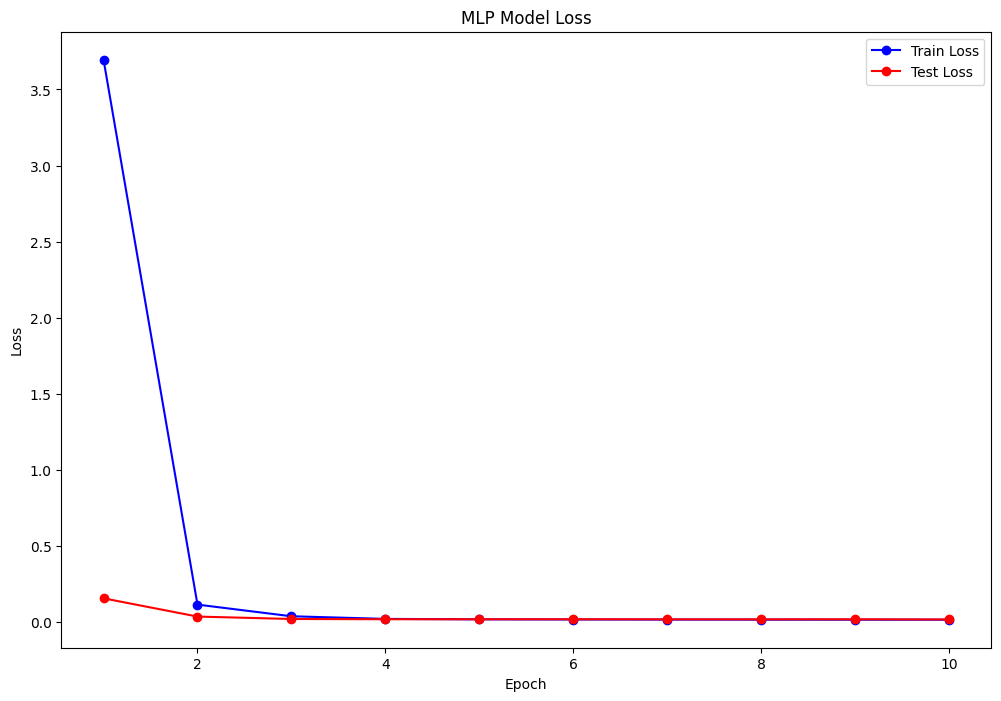

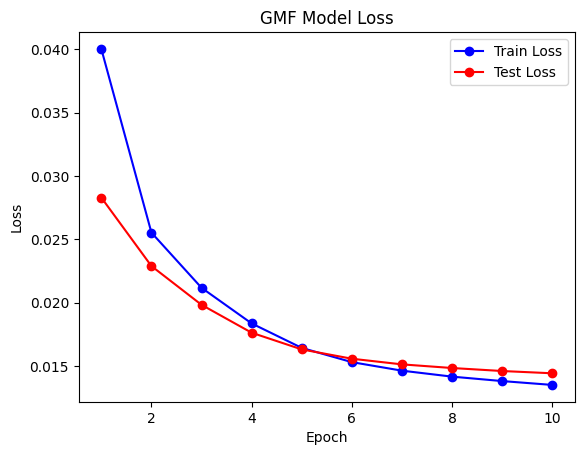

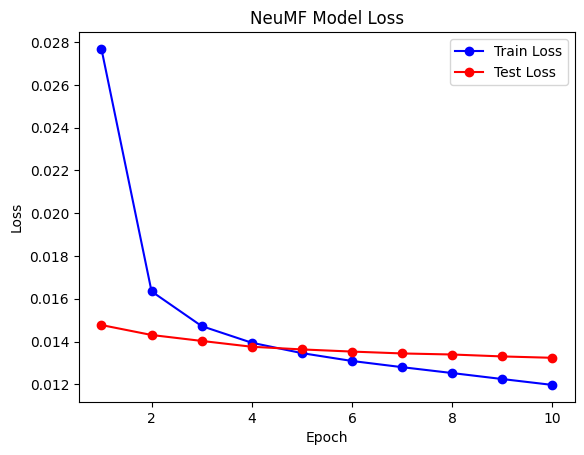

In [96]:
import matplotlib.pyplot as plt

# MLP model data
mlp_train_loss = [3.6950174334295, 0.11668900996973773, 0.040147326586463444, 0.022898902423949267, 0.019955833869365353, 
                  0.018866505908579186, 0.01828422652079384, 0.017863553787622624, 0.0176579500614437, 0.017454158246397105]
mlp_test_loss = [0.157952371776796, 0.03814665263147855, 0.022276981720272128, 0.0206319713626718, 0.020516480288159767, 
                 0.020635879038299828, 0.02011084193172132, 0.019992064000603074, 0.020253627192886033, 0.019198449493947483]

# GMF model data
gmf_train_loss = [0.04003728575764353, 0.025533486508182983, 0.021175410911702965, 0.018362480420187267, 0.016429371527416643, 
                  0.015305056382203475, 0.01463160192022472, 0.014160454717286095, 0.013809964230738773, 0.013505750678043297]
gmf_test_loss = [0.028299097051615502, 0.022891827709723422, 0.019831051891316644, 0.017628081791847532, 0.01631068073150627, 
                 0.015574246103732257, 0.015128253192493068, 0.014841098104719667, 0.014603769124104361, 0.014424409991700846]

# NeuMF model data
neumf_train_loss = [0.027678686989260452, 0.01634571377412012, 0.014723368335014456, 0.01394584908455086, 0.01346005102425137, 
                    0.013093187849867632, 0.012803735120885321, 0.01252872828114485, 0.012248591937687769, 0.011973678431735057]
neumf_test_loss = [0.014772928314505123, 0.014307665699783177, 0.01403033738548863, 0.013758254560114869, 0.013632847206995794, 
                   0.013532563343907766, 0.013445049989493694, 0.013395482611195579, 0.013305518026749452, 0.013241319170093422]

# Plotting the losses
plt.figure(figsize=(12, 8))

# MLP model loss
plt.plot(range(1, 11), mlp_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), mlp_test_loss, label="Test Loss", color='red', marker='o')
plt.title("MLP Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GMF model loss
plt.plot(range(1, 11), gmf_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), gmf_test_loss, label="Test Loss", color='red', marker='o')
plt.title("GMF Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# NeuMF model loss

plt.plot(range(1, 11), neumf_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), neumf_test_loss, label="Test Loss", color='red', marker='o')
plt.title("NeuMF Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [99]:
"""
MLP Model
Epoch [1/10], Loss: 3.6950174334295
Test Loss [1/10]: 0.157952371776796
Epoch [2/10], Loss: 0.11668900996973773
Test Loss [2/10]: 0.03814665263147855
Epoch [3/10], Loss: 0.040147326586463444
Test Loss [3/10]: 0.022276981720272128
Epoch [4/10], Loss: 0.022898902423949267
Test Loss [4/10]: 0.0206319713626718
Epoch [5/10], Loss: 0.019955833869365353
Test Loss [5/10]: 0.020516480288159767
Epoch [6/10], Loss: 0.018866505908579186
Test Loss [6/10]: 0.020635879038299828
Epoch [7/10], Loss: 0.01828422652079384
Test Loss [7/10]: 0.02011084193172132
Epoch [8/10], Loss: 0.017863553787622624
Test Loss [8/10]: 0.019992064000603074
Epoch [9/10], Loss: 0.0176579500614437
Test Loss [9/10]: 0.020253627192886033
Epoch [10/10], Loss: 0.017454158246397105
Test Loss [10/10]: 0.019198449493947483
Test MAE: 0.1104
Test RMSE: 0.1386
R² Score: 0.2205

GMF Model
Epoch [1/10], Loss: 0.04003728575764353
Test Loss [1/10]: 0.028299097051615502
Epoch [2/10], Loss: 0.025533486508182983
Test Loss [2/10]: 0.022891827709723422
Epoch [3/10], Loss: 0.021175410911702965
Test Loss [3/10]: 0.019831051891316644
Epoch [4/10], Loss: 0.018362480420187267
Test Loss [4/10]: 0.017628081791847532
Epoch [5/10], Loss: 0.016429371527416643
Test Loss [5/10]: 0.01631068073150627
Epoch [6/10], Loss: 0.015305056382203475
Test Loss [6/10]: 0.015574246103732257
Epoch [7/10], Loss: 0.01463160192022472
Test Loss [7/10]: 0.015128253192493068
Epoch [8/10], Loss: 0.014160454717286095
Test Loss [8/10]: 0.014841098104719667
Epoch [9/10], Loss: 0.013809964230738773
Test Loss [9/10]: 0.014603769124104361
Epoch [10/10], Loss: 0.013505750678043297
Test Loss [10/10]: 0.014424409991700846
Test MAE: 0.0909
Test RMSE: 0.1201
R² Score: 0.4143

NeuMF Model
Epoch [1/10], Loss: 0.027678686989260452
Test Loss [1/10]: 0.014772928314505123
Epoch [2/10], Loss: 0.01634571377412012
Test Loss [2/10]: 0.014307665699783177
Epoch [3/10], Loss: 0.014723368335014456
Test Loss [3/10]: 0.01403033738548863
Epoch [4/10], Loss: 0.01394584908455086
Test Loss [4/10]: 0.013758254560114869
Epoch [5/10], Loss: 0.01346005102425137
Test Loss [5/10]: 0.013632847206995794
Epoch [6/10], Loss: 0.013093187849867632
Test Loss [6/10]: 0.013532563343907766
Epoch [7/10], Loss: 0.012803735120885321
Test Loss [7/10]: 0.013445049989493694
Epoch [8/10], Loss: 0.01252872828114485
Test Loss [8/10]: 0.013395482611195579
Epoch [9/10], Loss: 0.012248591937687769
Test Loss [9/10]: 0.013305518026749452
Epoch [10/10], Loss: 0.011973678431735057
Test Loss [10/10]: 0.013241319170093422
Test MAE: 0.0870
Test RMSE: 0.1151
R² Score: 0.4624
"""

'\nMLP Model\nEpoch [1/10], Loss: 3.6950174334295\nTest Loss [1/10]: 0.157952371776796\nEpoch [2/10], Loss: 0.11668900996973773\nTest Loss [2/10]: 0.03814665263147855\nEpoch [3/10], Loss: 0.040147326586463444\nTest Loss [3/10]: 0.022276981720272128\nEpoch [4/10], Loss: 0.022898902423949267\nTest Loss [4/10]: 0.0206319713626718\nEpoch [5/10], Loss: 0.019955833869365353\nTest Loss [5/10]: 0.020516480288159767\nEpoch [6/10], Loss: 0.018866505908579186\nTest Loss [6/10]: 0.020635879038299828\nEpoch [7/10], Loss: 0.01828422652079384\nTest Loss [7/10]: 0.02011084193172132\nEpoch [8/10], Loss: 0.017863553787622624\nTest Loss [8/10]: 0.019992064000603074\nEpoch [9/10], Loss: 0.0176579500614437\nTest Loss [9/10]: 0.020253627192886033\nEpoch [10/10], Loss: 0.017454158246397105\nTest Loss [10/10]: 0.019198449493947483\nTest MAE: 0.1104\nTest RMSE: 0.1386\nR² Score: 0.2205\n\nGMF Model\nEpoch [1/10], Loss: 0.04003728575764353\nTest Loss [1/10]: 0.028299097051615502\nEpoch [2/10], Loss: 0.025533486